In [1]:
from pylab import *
import numpy as np


# Simulated annealing (global optimization)

Luca Magri (lm547@cam.ac.uk)

(With many thanks to Professor Gábor Csányi.)

- The optimization approach of this lecture is completely different from the optimation approaches we have studied so far
- It is not gradient based (it is not "$\nabla f(x)$-based")
- It is a probabilistic approach based on sampling (it is "$f(x)$-based")

## List of contents
- Limitations of local optimization methods
- Simulated annealing
- Example: The travelling salesperson problem

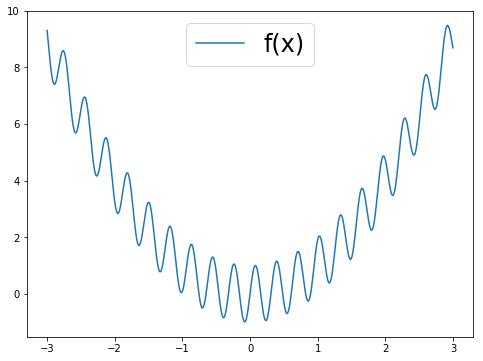

In [2]:
def f(x):
    return sin(20*x)+x**2

figure(figsize=(8,6))
x = np.linspace(-3,3,500)
plot(x, f(x), label="f(x)")
legend(loc=9, fontsize=24)
##show()

## Limitations of local optimization methods
- The methods we have studied so far are designed to find local minima  
  - If the function is convex, the local minimum is unique, hence it corresponds to the global minimum
  - However, functions in engineering can have multiple minima (i.e., functions may be non-convex)

- Finding a global minimum in non-convex functions is hard
 - One possible approach is to find as many local minima as possible starting with a random set of initial guesses, and then compare the values of the minima
 - This is in general not robust and can be very expensive
 
- Specific methods have been developed to find an approximate global minimum
 - In this lecture, we analyse the __simulated annealing__ algorithm  for the search of a global minimum
 

## Sampling $f(x)$

- Ideally, we could evaluate $f(x)$ in the range of interest
 - Practically, we cannot do so for all values of $f(x)$ (combinatorial explosion)
 - But we can sample $f(x)$ in some points 

How should we sample $f(x)$ starting from an initial guess $f(x_0)$?

Requirement we wish to impose:
1. We want to sample the function $f(x)$ within an _average_ range $T$ 
  - The higher $T$, the more values of $f$ we sample 


2. We want to sample in a way that we maximise the average information on the distribution of values of $f(x)$  
    - This means that we want to maximize the entropy (principle of maximum entropy)
    - Hence, the more likely we get out of local minima to explore other states
    - Because our goal is to minimize $f(x)$, let's called it _energy_, $f(x)=E(x)$
   

- The __Boltzmann distribution__ is the maximum entropy distribution for requirements 1 and 2  

  $$
  \text{Prob}(E(x)) \propto \exp{\left(-\frac{E(x)}{T}\right)}
   $$
  - This the probability distribution that best represents the current state of   knowledge subject to the constraint that the expected value of $E(x)$ is $T$
  - The probability of high values is exponentially smaller (but not zero) than the probability of low values, which is the property we use for global optimization

## Simulated annealing 

 - Strategy: 
  - We can model this as a __stochastic process__, a __Markov Chain__, and simulate it with a __Markov Chain Monte Carlo__ (MCMC) method, with a target distribution of $\exp(-E(x)/T)$. 
  - In a nutshell, this is
    - a probabilistic approach ...
    - ... with the Metropolis-Hastings algorithm to sample the function with a Boltzmann distribution as the target distribution with ... 
    - ... a simulated annealing schedule to vary the target distribution

- The analogy with global optimization is 
   
   \begin{array}{rcl}
   \text{Configuration } x & : & \textrm{The control variables of our problem}\;x\\
   \text{Energy } E & : &\textrm{The function we want to minimize}\; f(x)
   \end{array}
   
   
- We need a __proposal distribution__, i.e. a way to change the configuration $x$, and then follow the __Metropolis-Hastings__ rule for accepting or rejecting the proposal:

   $$
    \begin{array}{rcl}
     \text{Prob}(\text{accept } x\rightarrow x') &=& \min\left( \frac{e^{-E(x')/T}}{e^{-E(x)/T}},1\right)\\
     &=& \min\left( e^{-(E(x')-E(x))/T},1\right)\\
     &=& \min\left( e^{-\Delta E/T},1\right)\\
        \text{Move} & : & x_{n+1} {\stackrel{?}{\leftarrow}} x_n + U\left(-\frac12,\frac12\right)h \\ 
     \end{array}
     $$
   where $\Delta E$ is the energy change of the proposal.
- $e^{-\Delta E/T}$ is the Bolztmann factor 
- $U$ is the proposal distribution, which can involve any kind of _move_, as long as it respects _detailed balance_, and is _ergodic_. 
  - The easiest way to maintain detailed balance is to use a _symmetric_ move, and the easiest way to achieve ergodicity is to involve (pseudo)-random choices. Here, $U$ is the uniform distribution centred at $x=0$ and $h$ is the width/shift.
 - The algorithm will always accept a downhill move ($E_2=E(x')<E_1=E(x)$)
 - The algorithm will also samples states with $E_2>E_1$. This is an uphill move, which is never performed in the gradient-based methods we have studied
   - The uphill move avoids getting trapped in a local minimum
  - (For the Metropolis-Hastings rule, see the lectures on Stochastic Processes in this course) 

- Annealing corresponds to lowering the temperature slowly as the simulation of the stochastic process proceeds.
   $$
   T_{n+1} \leftarrow T_n\times (1-\textrm{rate})
   $$
   - The slower the rate, the better we approximate the target disitribution (Boltzmann distribution) at each temperature 
   - The lower the temperature, the smaller the range of sampled $\Delta E(x)$

In [3]:
def anneal(f, move, x0, T0, T1, rate, Ntraj=100):
    T = T0    # initial temperature
    x = x0    # initial position
    fx = f(x) # initial function value
    traj = [] # trajectory of MCMC
    n = 0     # counter
    # approx number of steps that will be taken
    Nsteps = int(floor(np.log(T1/T0)/np.log(1.0-rate)))
    # trajectory record interval to record 1000 steps
    traj_int = int(ceil(Nsteps/float(Ntraj)))
    while T > T1:
        # propose move
        xp = move(x)
        fp = f(xp)
        # decide if accept (Metropolis-Hastings algorithm)
        if np.random.random() < min(exp(-(fp-fx)/T), 1.0):
            x = xp
            fx = fp
        # lower the temperature (annealing schedule)
        T *= 1.0-rate
        if np.mod(n, traj_int) == 0:
         traj.append((x, fx, T))
        n += 1
    return traj

def fmove(x):
    return x+(np.random.random()-0.5)*0.2 #h=0.2, np.random.random() is the uniform distribution between 0 and 1
    

In [4]:
traj = anneal(f, fmove, 1.0, 4.0, 0.1, 1e-3)  

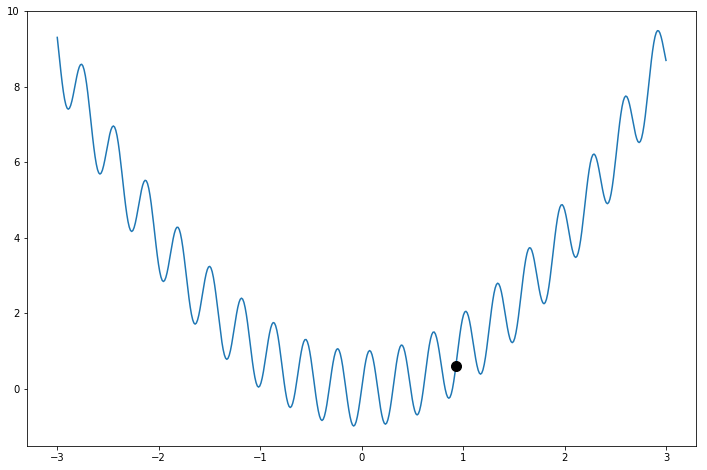

In [5]:
fig = figure(figsize=(12,8))
x = np.linspace(-3,3,500)
plot(x, f(x))
plot([traj[0][0]], [traj[0][1]], "ko", markersize=10)

def animate(i):
    gca().lines[1].set_xdata([traj[i][0]])
    gca().lines[1].set_ydata([traj[i][1]])

import matplotlib.animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(traj), interval=100)

from IPython.display import HTML
HTML(ani.to_jshtml())

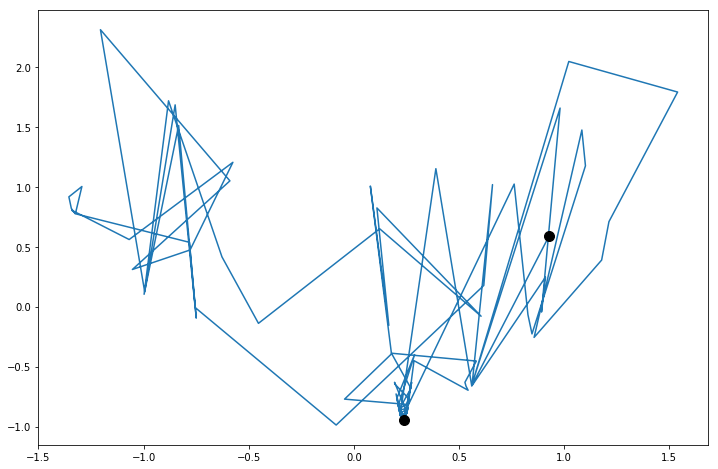

In [6]:
fig = figure(figsize=(12,8))
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))])
plot([traj[0][0],traj[99][0]], [traj[0][1],traj[99][1]], "ko", markersize=10)


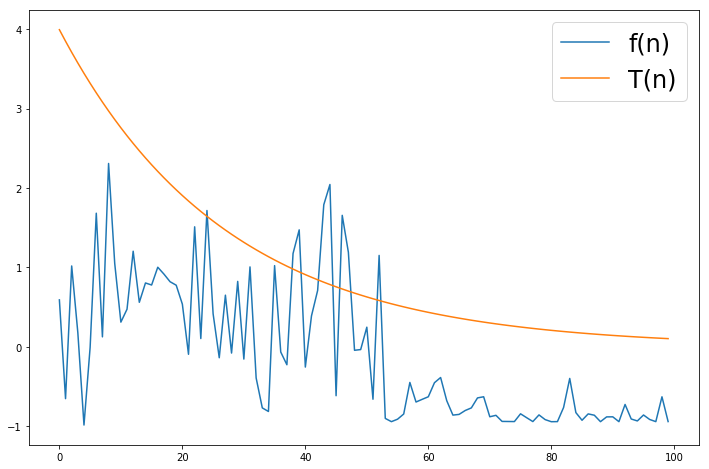

In [7]:
fig = figure(figsize=(12,8))
plot(range(len(traj)), [traj[i][1] for i in range(len(traj))], label="f(n)")
plot(range(len(traj)), [traj[i][2] for i in range(len(traj))], label="T(n)")
legend(loc=1, fontsize=24)

In [8]:
slowtraj = anneal(f, fmove, 2.0, 4.0, 0.1, 1e-5, Ntraj=1000)


[-3, 3, 0, 1]

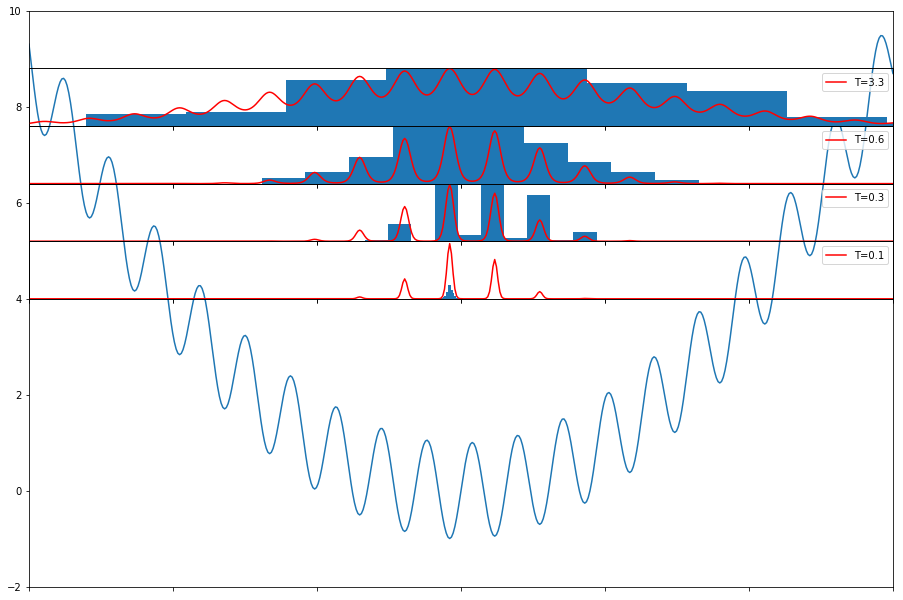

In [9]:
xtraj = [slowtraj[i][0] for i in range(len(slowtraj))];
Ttraj = [slowtraj[i][2] for i in range(len(slowtraj))];
E0=-1.0
fig=figure(figsize=(12,8))
x = np.linspace(-3,3,500)
axx = fig.add_axes([0,0,1,1])
axx.plot(x, f(x)); axx.axis([-3,3,-2,10]); 
ax = fig.add_axes([0,0.8,1,0.1], xticklabels=[], yticks=[]); ax.hist(xtraj[0:100]); ax.patch.set_alpha(0.0)
axis([-3,3,0,20])
ax = fig.add_axes([0,0.8,1,0.1], sharex=axx, xticklabels=[], yticks=[]); ax.plot(x, exp(-(f(x)-E0)/Ttraj[50]), 'r', label=("T=%.1f"%Ttraj[50])); ax.patch.set_alpha(0.0)
ax.legend(); axis([-3,3,0,1])
ax = fig.add_axes([0,0.7,1,0.1], xticklabels=[], yticks=[]); ax.hist(xtraj[400:600]); ax.patch.set_alpha(0.0)
axis([-3,3,0,30])
ax = fig.add_axes([0,0.7,1,0.1], sharex=axx, xticklabels=[], yticks=[]); ax.plot(x, exp(-(f(x)-E0)/Ttraj[500]), 'r', label=("T=%.1f"%Ttraj[500])); ax.patch.set_alpha(0.0)
ax.legend(); axis([-3,3,0,1])
ax = fig.add_axes([0,0.6,1,0.1], xticklabels=[], yticks=[]); ax.hist(xtraj[600:800]); ax.patch.set_alpha(0.0)
axis([-3,3,0,50])
ax = fig.add_axes([0,0.6,1,0.1], sharex=axx, xticklabels=[], yticks=[]); ax.plot(x, exp(-(f(x)-E0)/Ttraj[700]), 'r', label=("T=%.1f"%Ttraj[700])); ax.patch.set_alpha(0.0)
ax.legend(); axis([-3,3,0,1])
ax = fig.add_axes([0,0.5,1,0.1], xticklabels=[], yticks=[]); ax.hist(xtraj[800:1000]); ax.patch.set_alpha(0.0)
axis([-3,3,0,200])
ax = fig.add_axes([0,0.5,1,0.1], sharex=axx, xticklabels=[], yticks=[]); ax.plot(x, exp(-(f(x)-E0)/Ttraj[900]), 'r', label=("T=%.1f"%Ttraj[900])); ax.patch.set_alpha(0.0)
ax.legend(); axis([-3,3,0,1])




## The analogy with annealing
 - __Annealing__: 
   - Heat treatement of materials
   - Heating
   - Keep high temperature for some time
   - Slow cooling to reach equilibrium, i.e., the Boltzmann distribution
   - Configuration with low energy (e.g., few defects)
   
- Atoms diffuse within the alloy to find a configuration with lower energy
- The more atoms are free to diffuse, the more energy states are sampled, the more likely approach a global minimum as the temperature slowly decreases

![annealing](https://cdn.instructables.com/FV1/SUHN/J2KPDQ1X/FV1SUHNJ2KPDQ1X.LARGE.jpg)

## How can this go wrong? 

- Stopping while still too hot
- Too fast cooling
- Inappropriate proposal distribution (e.g. too small or too large steps)


In [10]:
traj = anneal(f, fmove, 2.0, 4.0, 0.1, 1e-1) # rate is two orders of magnitude larger now

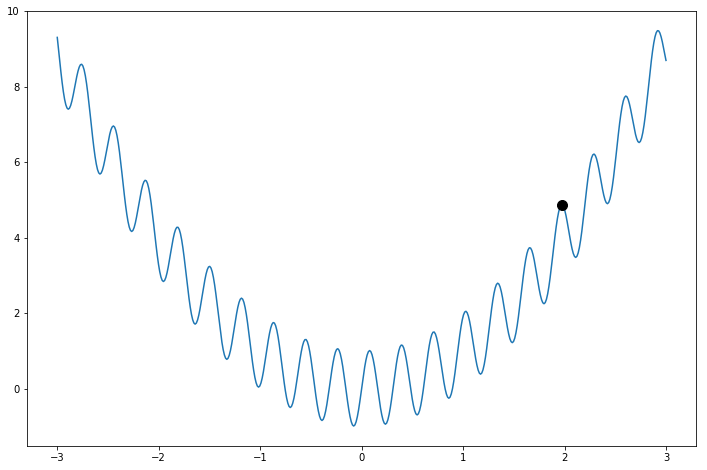

In [11]:
fig = figure(figsize=(12,8))
x = np.linspace(-3,3,500)
plot(x, f(x))
plot([traj[0][0]], [traj[0][1]], "ko", markersize=10)


def animate(i):
    gca().lines[1].set_xdata([traj[i][0]])
    gca().lines[1].set_ydata([traj[i][1]])

import matplotlib.animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(traj), interval=100)

from IPython.display import HTML
HTML(ani.to_jshtml())

## Real world uses

- You cannot assume that it is possible to jump from minimum to minimum
- Scale of proposal distribution has to be adjusted on-the-fly - difficult to do without breaking detailed balance
- "Clever" new types of moves make a _huge_ difference, can make a very hard problem tractable
- Annealing schedules can be optimised
- Many "walkers" can be handled in parallel
- Parallel tempering: multiple temperatures can be handled simultaneously, rather than traversed from hot to cold: costs more, but avoids getting trapped. 

## Challenges in discrete global optimization and combinatorial explosion

- When the configuration space includes a discrete _combination_ of choices, the number of local minima can be extremely large
- This is sometimes informally called combinatorial explosion (or curse of dimensionality) 
   - Example: The travelling salesperson problem. "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

- Many good solutions are separated from each other by worse solutions
 - Gradient-based optimisation may get ''trapped'' in a local minimum, which may be far from the global minimum. 

- Computationally, we rarely have the resources to compute all the candidate minima  
  - Thus, we cannot guarantee that we have found the global optimum
  - We will be content, however, with a ''probable'' global minimum solution. 





## Example: The travelling salesperson problem

A prototypical hard optimisation problem with combinatorial explosion.

You have N locations on the map, with distances between them given by $d_{ij}$, with $i,j = 1\ldots N$, and you are looking for the shortest route $R$ that visits all locations. 

Formally: a route $R$ is an ordered list of locations, so $R(1)$ is visited first, then $R(2)$ etc. until $R(N)$. 

The length of the route is

$$
L(R) = \sum_{i=1}^{N-1} d_{R(i),R(i+1)}
$$

Given the distance matrix $d_{ij}$, minimize $L(R)$ over all possible ($N!$) orderings.

To solve with simulated annealing, all we need is a "move", a way to generate a new route from an existing route, i.e.  a proposal distribution. 

One possibility is to propose to reverse (swap) the order of visiting two randomly chosen locations $j$ and $j'$:

$$
R'(i) = 
\begin{cases}
R(i) &\text{for } i \neq j,j'\\
R(j) & \text{for } i = j'\\
R(j')& \text{for } i = j\\
\end{cases}
$$

## Write a program to optimise the route

In [12]:
Nloc = 20
xy = np.random.random((Nloc,2))
d2 = np.zeros((Nloc,Nloc))
for i in range(Nloc):
    for j in range(Nloc):
        d2[i,j] = (xy[i,0]-xy[j,0])**2+(xy[i,1]-xy[j,1])**2
        

In [13]:
def TSanneal(f, move, x0, T0, T1, rate, Ntraj=100):
    T = T0    # initial temperature
    x = x0.copy()    # initial position
    fx = f(x) # initial function value
    traj = [] # trajectory of MCMC
    n = 0     # counter
    # approx number of steps that will be taken
    Nsteps = int(floor(np.log(T1/T0)/np.log(1.0-rate)))
    # trajectory record interval to record 1000 steps
    traj_int = int(ceil(Nsteps/float(Ntraj)))
    traj.append((x.copy(), fx, T))
    xp = x.copy();
    while T > T1:
        if np.mod(n, traj_int) == 0:
            traj.append((x.copy(), fx, T))
        # propose move
        move(x, xp)
        fp = f(xp)
        # decide if accept
        if np.random.random() < min(exp(-(fp-fx)/T), 1.0):
            x[:] = xp[:]
            fx = fp
        # lower the temperature
        T *= 1.0-rate      
        n += 1
    return traj

def TSmove(R, RR):
    i=np.random.randint(Nloc)
    j=np.random.randint(Nloc)
    RR[:] = R[:]
    RR[i] = R[j]
    RR[j] = R[i]
    return

def TSmove2(R, RR):
    i=np.random.randint(Nloc)
    j=np.random.randint(Nloc)
    RR[:] = R[:]
    if j<i:
        RR[j:i+1] = R[j:i+1][::-1]
    else:
        RR[i:j+1] = R[i:j+1][::-1]
    return


def routeL(R):
    L=0
    for i in range(Nloc-1):
        L += d2[R[i],R[i+1]]
    return L
    
R0 = np.random.permutation(Nloc).copy()

traj = TSanneal(routeL, TSmove2, R0, 5.0, 0.001, 1e-4, Ntraj=20)

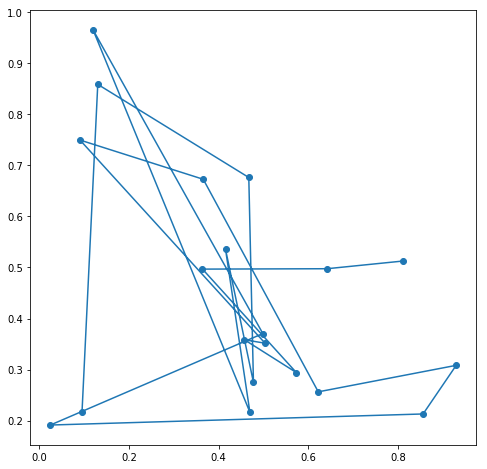

In [14]:
fig = figure(figsize=(8,8))
plot([xy[traj[0][0][i],0] for i in range(Nloc)], [xy[traj[0][0][i],1] for i in range(Nloc)], "o-")

def animate(n):
    gca().lines[0].set_xdata([xy[traj[n][0][i],0] for i in range(Nloc)])
    gca().lines[0].set_ydata([xy[traj[n][0][i],1] for i in range(Nloc)])

import matplotlib.animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(traj), interval=200)

from IPython.display import HTML
HTML(ani.to_jshtml())